# Predictive Analytics for Term Deposit Campaign Optimization

## Executive Summary

Marketing campaigns play a critical role in promoting term deposit products within banking. However, contacting every customer is both costly and inefficient, often resulting in low conversion rates and unnecessary outreach expenses.

This project develops a predictive classification model to identify customers who are most likely to subscribe to a term deposit. The objective is to improve campaign efficiency, reduce operational costs, and increase overall conversion performance.

Rather than focusing solely on model accuracy, this analysis emphasizes:

- Selecting evaluation metrics aligned with business impact  
- Maintaining model interpretability for stakeholder transparency  
- Optimizing probability thresholds to support strategic targeting decisions  
- Applying structured validation techniques to ensure reliability and robustness  

The result is an end-to-end analytical workflow designed to reflect real-world banking operations and decision-making processes.



## 1️. Business Understanding

### Problem Statement

The bank runs outbound marketing campaigns to promote term deposit products. However, only a small fraction of contacted customers actually subscribe.

When campaigns are not targeted effectively, the result is:

- High operational and contact center costs  
- Low conversion efficiency  
- Sales team fatigue from repeated low-yield outreach  
- Reduced return on marketing investment 

In short, the bank spends significant resources contacting customers who are unlikely to convert.

### Strategic Objective

The goal of this project is to develop a predictive model that:

- Identifies customers with a high probability of subscribing  
- Enables prioritized and focused marketing outreach  
- Improves overall campaign targeting efficiency  

Rather than increasing outreach volume, the strategy is to improve outreach quality.

### Business Considerations

From a business perspective, prediction errors carry different costs:

- **False Negatives (Missed Subscribers):** Potential revenue is lost by failing to contact customers who would have subscribed.  
- **False Positives (Unlikely Subscribers Contacted):** Marketing resources are spent on customers who are unlikely to convert.  

The model must therefore balance recall and precision carefully, aligning performance with real business trade-offs rather than optimizing for accuracy alone.


## 2️. Data Overview

To address the business objective, two datasets are provided:

- **train.csv** – Historical campaign data that includes customer attributes and the subscription outcome.  
- **test.csv** – Customer records without subscription outcomes, simulating future campaign targets.  

The training dataset will be used to:

- Perform exploratory data analysis (EDA)  
- Train and validate predictive models  
- Optimize probability thresholds for business-aligned decision-making  

The test dataset will be used to simulate deployment, generating predictions for future campaign targeting.

In [5]:
# ================================
# Imports & Environment Setup
# ================================

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option("display.max_columns", None)

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)


In [6]:
# ================================
# Load Data
# ================================

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (750000, 18)
Test shape: (250000, 17)


In [7]:
# Display first few rows of the dataframe
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


### Gather basic information about the data


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


## Data Structure Overview

The training dataset consists of:

- **750,000 customer records**
- **18 total columns**
- **17 predictive features and 1 target variable (`y`)**
- **No detected missing values**

### Feature Composition

The dataset includes:

- **9 numerical variables** (`int64`)  
- **9 categorical variables** (`object`)  

This balance of numerical and categorical features requires a structured preprocessing approach, particularly for encoding categorical variables while preserving model interpretability.

### Key Observations

1. **Large Dataset Size (750k rows)**  
   The volume provides strong statistical power, but it also requires memory-efficient preprocessing and scalable model training techniques.

2. **No Missing Values**  
   The absence of missing data simplifies preprocessing and eliminates the need for imputation strategies.

3. **Presence of an `id` Column**  
   The `id` variable serves as a unique identifier and carries no predictive signal. It will be excluded from model training.

4. **Target Variable (`y`)**  
   The problem is framed as a binary classification task (0 = No subscription, 1 = Subscription).  
   Class distribution will be evaluated to assess potential imbalance.

---

### Business Context

The dataset captures three critical dimensions of customer behavior:

- **Demographic characteristics** (e.g., age, job, marital status, education)  
- **Financial indicators** (e.g., account balance, loan status, default history)  
- **Campaign interaction history** (e.g., contact type, call duration, previous outcomes)

This structure allows the model to evaluate not only who the customer is, but also how they have historically engaged with marketing efforts.

From a predictive standpoint, this combination of static customer attributes and behavioral interaction data creates a strong foundation for targeted campaign optimization.

### Gather descriptive statistics about the data

In [12]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


## Numerical Feature Insights

The dataset contains 750,000 customer records. Below are the most relevant numerical patterns observed during exploratory analysis and their implications for modeling.

---

### 1️. Target Variable (`y`)

- Mean = **0.1206**
- ~12% subscription rate  

Only about 1 in 8 customers subscribed to a term deposit. This confirms that the dataset is **highly imbalanced**, which is typical for marketing campaigns where positive responses are relatively rare.

Because of this imbalance, accuracy alone would provide a distorted view of model performance. Evaluation will instead prioritize:

- Precision  
- Recall  
- F1-score  
- ROC-AUC  

These metrics better reflect the business trade-off between missed subscribers and unnecessary outreach.

---

### 2️. Age

- Range: 18 to 95  
- Median: 39  
- Mean: ~41  

The customer base spans a wide demographic range, with the middle 50% concentrated roughly between 33 and 48 years.

This indicates broad targeting across age groups rather than a narrowly defined demographic segment.

---

### 3️. Balance

- Mean: 1204  
- Median: 634  
- Min: -8019  
- Max: 99,717  
- Large standard deviation  

Account balance is highly skewed. Some customers are overdrawn, while others hold substantial funds.

This variation reflects diverse financial profiles and suggests that transformation or scaling may be necessary during modeling to manage skewness effectively.

---

### 4️. Duration

- Mean: 256 seconds  
- Median: 133 seconds  
- Max: 4918 seconds (~82 minutes)  

`duration` represents the length of the marketing call.

However, the objective of this project is to predict which customers should be contacted *before* a call takes place. Since call duration is only known after the interaction, including it would introduce **data leakage**, leading to artificially inflated model performance.

To maintain realistic and deployable predictions, this feature will be excluded from modeling.

---

### 5️. Campaign

- Mean: 2.57 contact attempts  
- Max: 63 contact attempts  

While most customers were contacted a few times, some received more than 60 calls.

This raises operational concerns around customer fatigue and inefficient targeting. Excessive contact attempts may reduce effectiveness and increase campaign costs.

---

### 6️. Pdays

- Median: -1  
- 75th percentile: -1  
- Max: 871  

A value of `-1` likely indicates no previous contact.

The fact that most customers fall into this category suggests that a large portion of the dataset consists of first-time outreach candidates. Proper encoding of this variable will be important during feature engineering.

---

### 7️. Previous

- Median: 0  
- Max: 200  

Most customers have no prior campaign interactions. However, a smaller subset has extensive historical engagement, which may significantly influence subscription probability.


In [14]:
# ================================
# Check for Duplicate Rows
# ================================

duplicate_count = train.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


## Duplicate Record Check

Before proceeding with feature selection and model preparation, the dataset was evaluated for duplicate records.

- **Number of duplicate rows:** 0  

No duplicate observations were detected. This indicates that each row represents a unique customer interaction, and no additional cleaning steps are required in this regard.

With data integrity confirmed, the analysis can proceed to feature preparation and modeling.


## Feature Removal Before Modeling

With data integrity confirmed, the next step is to remove features that should not be included in model training.

Two variables are excluded:

- **`duration`**  
  This feature represents the length of the marketing call. Since the objective is to predict subscription likelihood *before* a customer is contacted, call duration would not be available at prediction time. Including it would introduce **data leakage**, resulting in unrealistically high model performance.

- **`id`**  
  This column functions solely as a unique identifier and carries no predictive value.

Removing these variables ensures that the model remains realistic, deployable, and aligned with the business objective of pre-campaign targeting.

In [17]:
# ================================
# Drop Non-Predictive Features
# ================================

train = train.drop(columns=["duration", "id"])
test = test.drop(columns=["duration", "id"])

print("Updated train shape:", train.shape)
print("Updated test shape:", test.shape)


Updated train shape: (750000, 16)
Updated test shape: (250000, 15)


## Visual Exploration of Numerical Features

While summary statistics provide a useful numerical overview, visualizing feature distributions offers deeper insight into skewness, outliers, and structural patterns that may affect model behavior.

Several variables particularly **balance**, **campaign**, and **pdays** display extreme or highly skewed values. These characteristics can influence model stability, scaling requirements, and overall predictive performance.

Visual inspection allows us to validate earlier observations and determine whether transformation, capping, or additional feature engineering may be necessary before training the model.

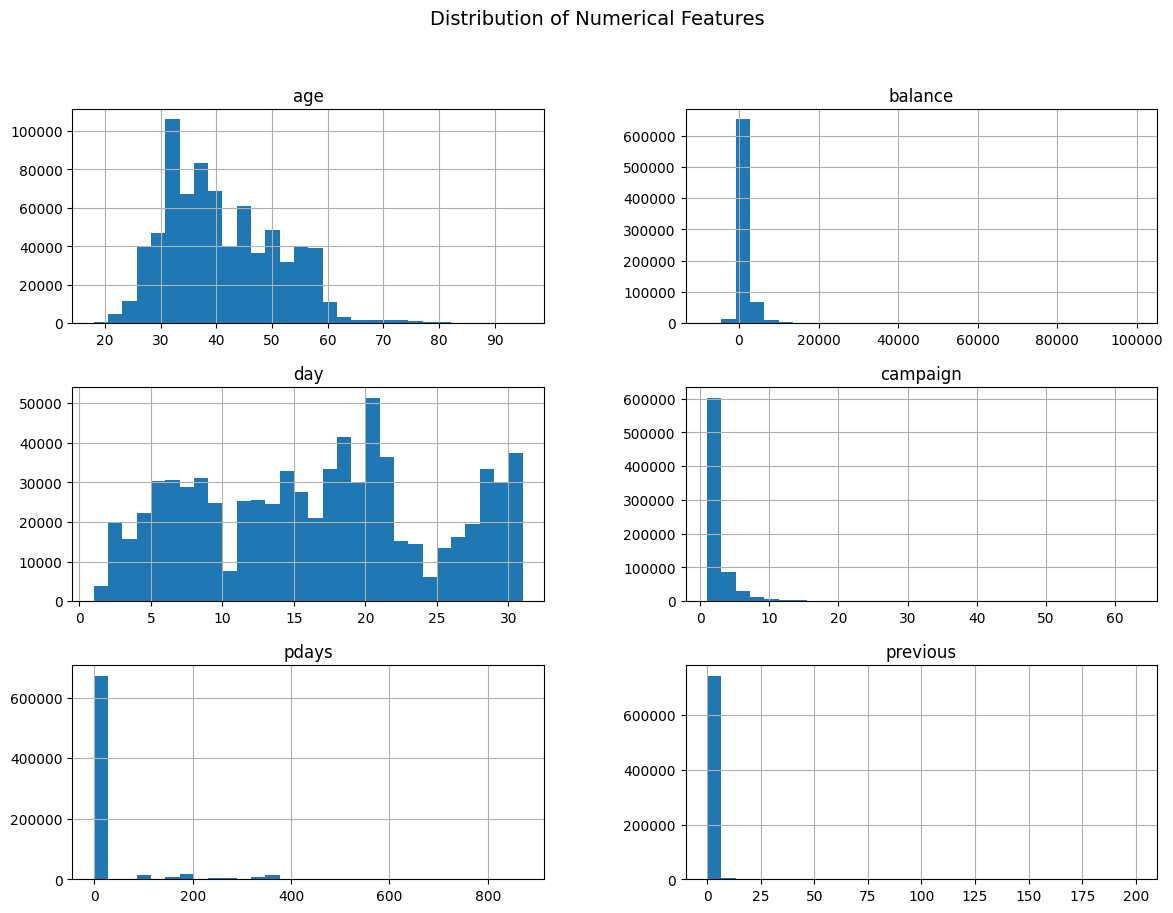

In [19]:
# ================================
# Distribution of Numerical Features
# ================================

numeric_cols = train.select_dtypes(include="int64").columns.drop("y")

train[numeric_cols].hist(figsize=(14,10), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()


### Distribution of Numerical Features

The histograms provide a clearer view of how key numerical variables are distributed across the customer base:

- **Age** appears relatively well distributed, with most clients concentrated between their 30s and 50s. The pattern suggests a broad working-age population rather than extreme age clustering.

- **Balance** is heavily right-skewed. Most customers hold modest account balances, while a small subset maintains exceptionally high values. This skewness may influence model sensitivity and could warrant transformation.

- **Campaign** also shows strong skewness. The majority of customers were contacted only a few times, but a small group received repeated outreach attempts. This long tail may reflect inefficient targeting practices.

- **Pdays** presents a sharp spike at very low values, including the common `-1` indicator, which likely represents no prior contact. This reinforces the earlier observation that most customers were first-time outreach candidates.

- **Previous** is concentrated near zero, indicating minimal historical campaign interaction for the majority of clients.

Overall, several numerical features display skewness and outliers. These distributional characteristics are important to consider when selecting models, applying transformations, and evaluating performance stability.

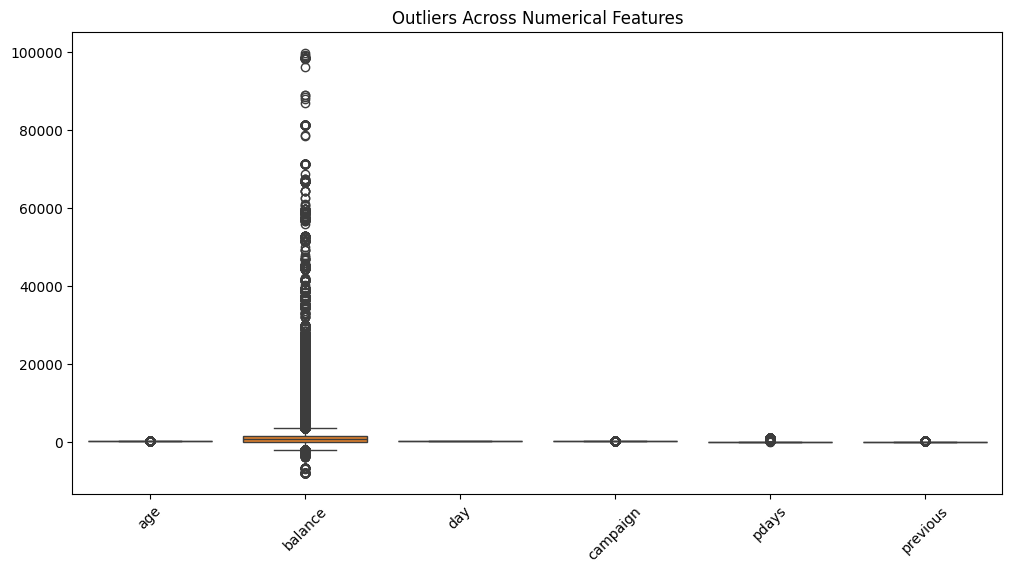

In [21]:
# ================================
# Boxplots for Outlier Detection
# ================================

plt.figure(figsize=(12,6))
sns.boxplot(data=train[numeric_cols])
plt.title("Outliers Across Numerical Features")
plt.xticks(rotation=45)
plt.show()

### Outliers Across Numerical Features

The grouped boxplots further highlight the presence of outliers across several numerical variables.

**Balance** exhibits the widest spread, with a small subset of customers holding exceptionally large positive or negative account values. This reinforces the earlier observation of strong right skew and financial variability within the customer base.

Variables such as **campaign**, **pdays**, and **previous** also display right-skewed distributions. Most customers were contacted only a few times, while a small group experienced repeated outreach attempts, creating long-tailed patterns.

In contrast, **age** remains comparatively stable, with fewer extreme values relative to other numerical features.

These distributional patterns are typical in real-world financial datasets. However, they are important to account for during model selection and preprocessing. Certain algorithms — such as Logistic Regression — can be sensitive to extreme values, making scaling or transformation strategies potentially necessary.




## Categorical Feature Exploration

Beyond numerical attributes, the dataset also includes several categorical variables such as job type, education level, contact method, and previous campaign outcomes.

These features are particularly important in a marketing context, as customer response behavior often varies across demographic and engagement segments.

Exploring categorical variables serves multiple purposes:

- Identifying dominant and underrepresented customer groups  
- Detecting rare or “unknown” categories that may require special handling  
- Preparing for appropriate encoding prior to model training  

The next step is to systematically identify all categorical columns and examine their distribution across the customer base.

In [24]:
# ================================
# Identify Categorical Features
# ================================

categorical_cols = train.select_dtypes(include='object').columns
print("Categorical Features:")
print(list(categorical_cols))


Categorical Features:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [25]:
# ================================
# Frequency Distribution of Categorical Features
# ================================

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    display(train[col].value_counts(normalize=True).head(5) * 100)



--- JOB ---


job
management     23.405467
blue-collar    22.733067
technician     18.414267
admin.         10.865600
services        8.561200
Name: proportion, dtype: float64


--- MARITAL ---


marital
married     64.101200
single      25.977867
divorced     9.920933
Name: proportion, dtype: float64


--- EDUCATION ---


education
secondary    53.557733
tertiary     30.334400
primary      13.268000
unknown       2.839867
Name: proportion, dtype: float64


--- DEFAULT ---


default
no     98.2868
yes     1.7132
Name: proportion, dtype: float64


--- HOUSING ---


housing
yes    54.8384
no     45.1616
Name: proportion, dtype: float64


--- LOAN ---


loan
no     86.003067
yes    13.996933
Name: proportion, dtype: float64


--- CONTACT ---


contact
cellular     64.887333
unknown      30.883600
telephone     4.229067
Name: proportion, dtype: float64


--- MONTH ---


month
may    30.454800
aug    17.181200
jul    14.752933
jun    12.489333
nov     8.808267
Name: proportion, dtype: float64


--- POUTCOME ---


poutcome
unknown    89.660000
failure     6.015333
success     2.358800
other       1.965867
Name: proportion, dtype: float64

### Categorical Feature Insights

The categorical variables reveal clear customer segmentation patterns, along with a few important considerations for modeling and data quality.

- **Job** categories are diverse, with *management*, *blue-collar*, and *technician* representing the largest segments. This suggests that occupation may meaningfully influence subscription likelihood and should retain predictive importance.

- **Marital status** is dominated by *married* clients (~64%), indicating the dataset is skewed toward established households.

- **Education** is primarily concentrated in *secondary* and *tertiary* levels, while *unknown* education represents only a small portion of the data.

- **Default status** is overwhelmingly *no* (~98%). Given the low variance, this feature may offer limited predictive signal.

- **Housing** and **personal loan** status are relatively common, potentially reflecting financial obligations that could affect a customer’s ability or willingness to commit to a term deposit.

- **Contact method** includes a substantial *unknown* category (~31%). This may reflect incomplete campaign tracking and should be handled carefully during preprocessing to avoid signal distortion.

- **Month** demonstrates noticeable seasonality, with May and August accounting for a significant share of campaign activity. This suggests potential temporal patterns in outreach strategy.

- **Previous campaign outcome (`poutcome`)** is largely *unknown* (~90%), indicating limited historical engagement data for most customers. This reduces its standalone usefulness but may still provide value when combined with related variables.

Overall, these categorical patterns reinforce the importance of segmentation in marketing response modeling. Appropriate encoding and thoughtful treatment of “unknown” categories will be critical before training predictive models.

## Categorical Features vs Subscription Outcome

After examining the overall distribution of categorical variables, the next step is to analyze how these customer segments relate to the target outcome (`y`).

This moves the analysis from description to impact, helping determine whether certain groups are more likely to subscribe to a term deposit.

Key business questions at this stage include:

- Do certain occupations exhibit higher subscription rates?
- Does education level influence deposit decisions?
- Are specific contact channels more effective than others?
- Does previous campaign success meaningfully increase future subscription likelihood?

Evaluating these relationships provides early directional insight into which customer segments are most responsive to marketing efforts and where targeted outreach may yield the strongest returns.

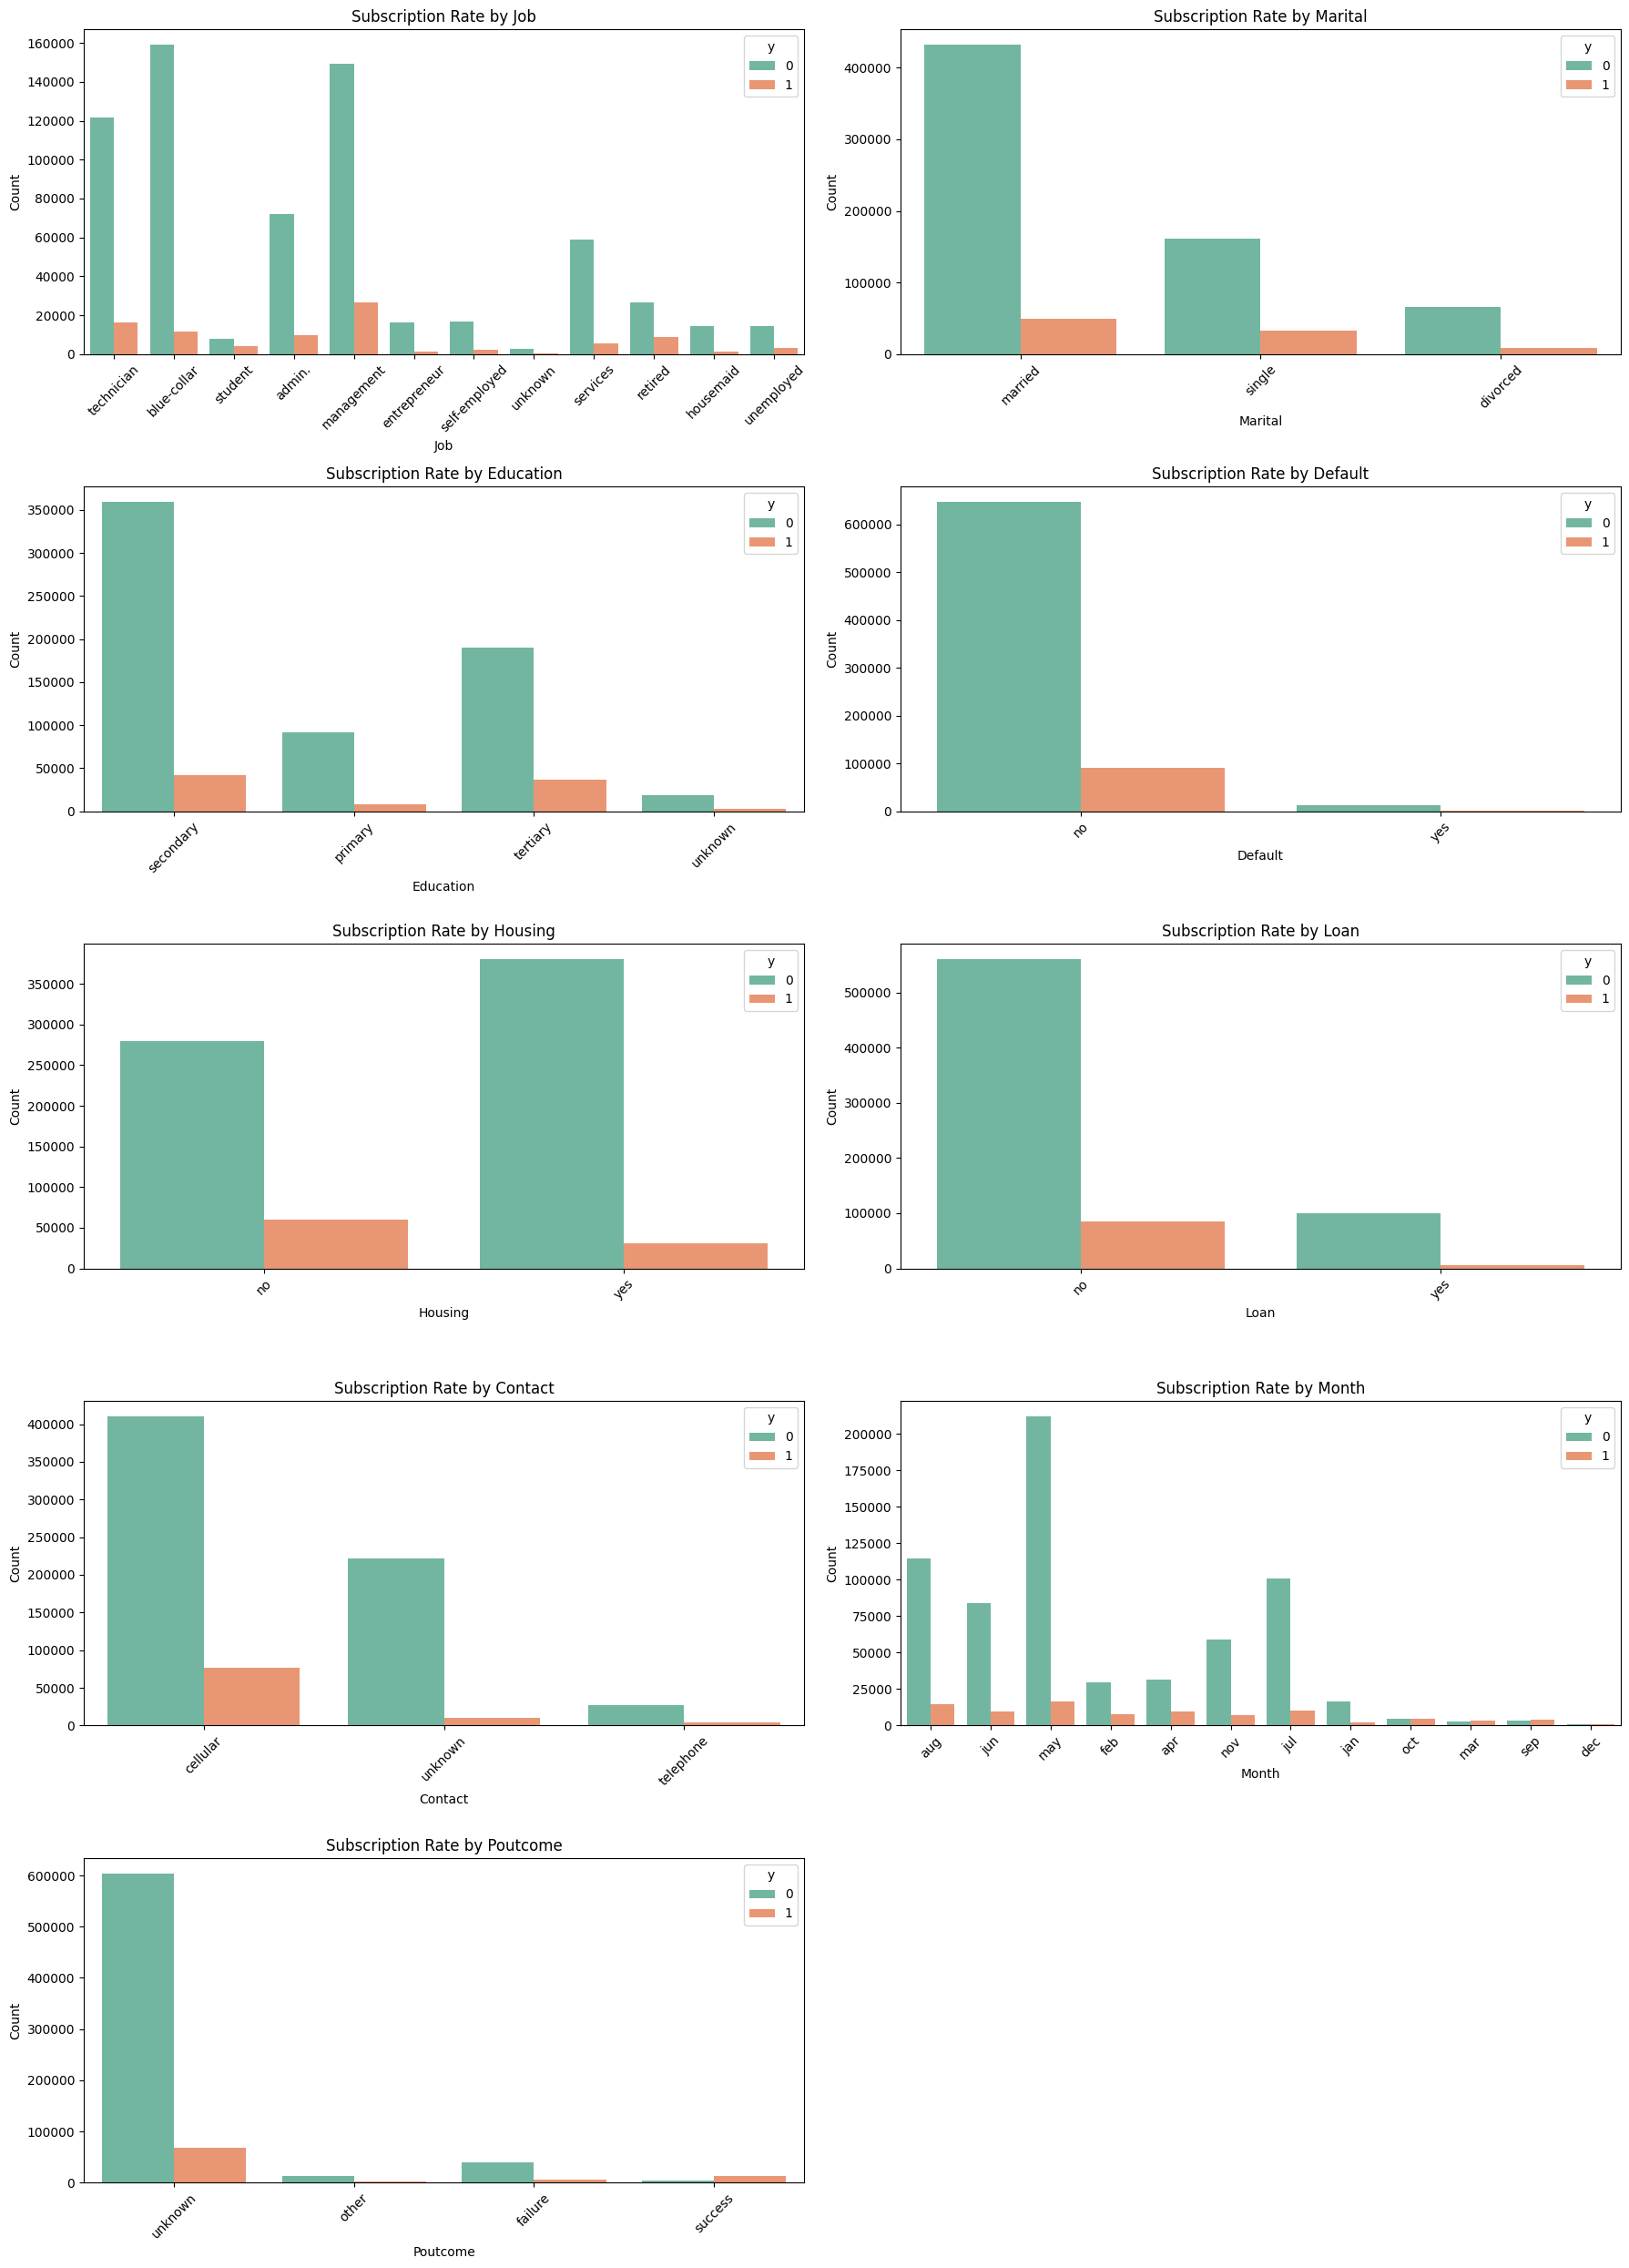

In [28]:
# ================================
# Subscription Rate by Categorical Features
# ================================

categorical_cols = ['job', 'marital', 'education', 'default', 
                    'housing', 'loan', 'contact', 'month', 'poutcome']

plt.figure(figsize=(18, 25))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(5, 2, i)
    sns.countplot(x=col, hue='y', data=train, palette='Set2')
    plt.title(f'Subscription Rate by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Relationship Between Categorical Features and Subscription Outcome

The visual comparisons reveal clear variation in subscription behavior across customer segments.

- **Job** and **education** display noticeable differences in subscription rates, indicating that occupation and socio-economic background may influence deposit decisions.

- **Contact method** emerges as a meaningful factor. Customers reached via **cellular** channels appear significantly more likely to subscribe than those labeled as *unknown*, highlighting the importance of reliable and well-documented outreach methods.

- **Previous campaign outcome (`poutcome`)** shows a particularly strong signal. Customers with a prior **successful** campaign outcome demonstrate substantially higher subscription rates. In contrast, the large *unknown* segment reflects limited engagement history, reducing predictive clarity for that group.

- **Month of contact** suggests seasonal variation, implying that campaign timing may influence conversion performance.

Overall, these findings reinforce that subscription likelihood is shaped not only by customer financial characteristics, but also by engagement history and communication strategy. From a targeting perspective, segmentation and channel effectiveness play a critical role in campaign optimization.


### Numerical Features vs Subscription Outcome

Following the review of overall distributions and categorical segmentation, the next step is to compare key numerical variables across the two outcome groups; customers who subscribed (`y = 1`) and those who did not (`y = 0`).

This comparison helps uncover quantitative patterns that may influence subscription behavior, such as differences in account balance, contact frequency, or prior campaign engagement.

Boxplots are particularly useful for this analysis, as they allow for direct comparison of medians, variability, and outlier behavior between the two groups. Observing shifts in central tendency or spread can provide early signals about which numerical features may carry predictive value.

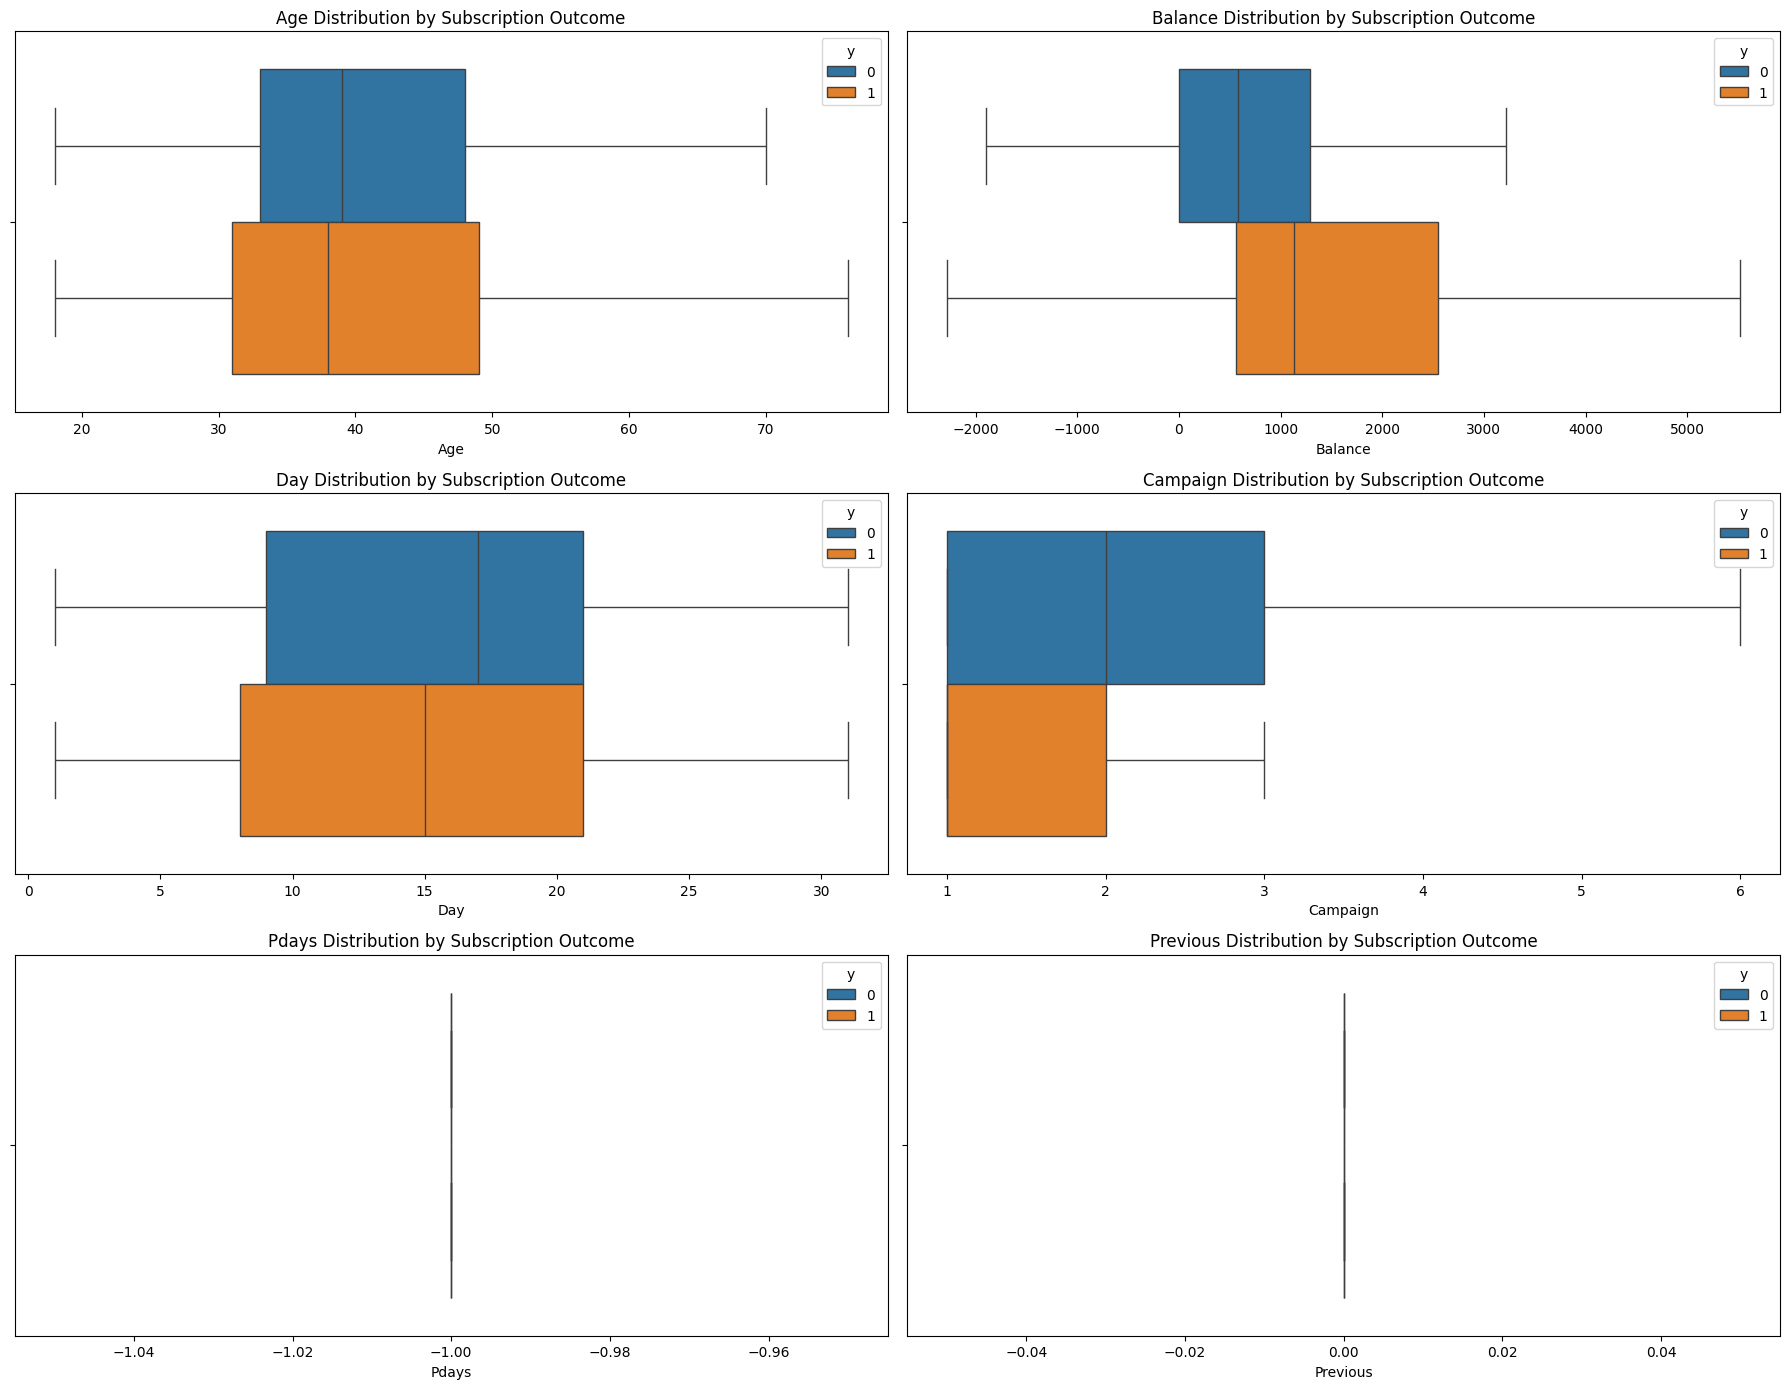

In [31]:
# ============================================
# Numerical Features vs Target (Colored Boxplots)
# ============================================

numeric_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(18, 14))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)

    sns.boxplot(
        data=train,
        x=col,
        hue='y',          
        orient="h",
        showfliers=False  
    )

    plt.title(f"{col.capitalize()} Distribution by Subscription Outcome")
    plt.xlabel(col.capitalize())
    plt.ylabel("")

plt.tight_layout()
plt.show()

### Numerical Features vs Subscription Outcome

To better understand what differentiates subscribers (`y = 1`) from non-subscribers (`y = 0`), the distributions of key numerical variables were compared using boxplots.

Key observations include:

- **Balance** shows the clearest separation. Customers who subscribed generally maintain higher account balances, suggesting greater financial capacity or stronger savings intent.

- **Campaign** displays an inverse pattern: subscribers typically required fewer contact attempts. Customers contacted repeatedly appear less likely to convert, indicating that early engagement success may be more valuable than repeated outreach.

- **Age** distributions are broadly similar across both groups, although subscribers exhibit a slightly higher median age. This suggests that age may carry a modest signal, but not a dominant one.

- **Day of month** shows minimal differentiation between the two groups, implying limited predictive relevance.

Overall, these comparisons suggest that financial strength and campaign intensity provide stronger quantitative signals than basic timing variables. This reinforces the importance of strategic targeting over repeated contact volume.

## Correlation Analysis (Numeric Features)

To conclude the exploratory analysis, we evaluate the correlations among numerical variables.

A correlation heatmap provides a structured view of linear relationships across features and helps identify:

- Strong associations between predictors  
- Potential redundancy from overlapping variables  
- Direct linear relationships with the target variable  

This step is particularly important prior to model training. Highly correlated inputs can introduce multicollinearity, which may affect interpretability in models such as Logistic Regression. 

Understanding these relationships also highlights potential feature engineering opportunities and ensures that the modeling phase begins with a well-informed perspective on variable interactions.

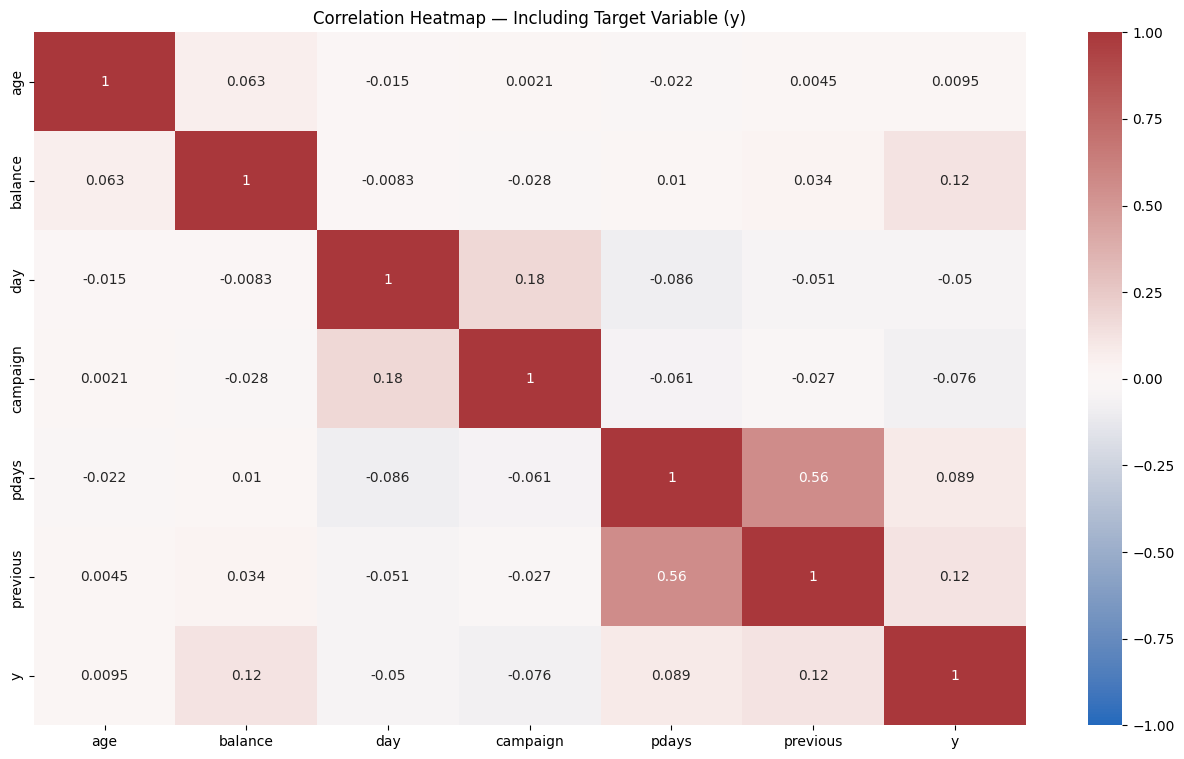

In [34]:
# ================================
# Correlation Heatmap
# ================================

numeric_df = train.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(16, 9))
sns.heatmap(
    numeric_df.corr(),
    vmin=-1, vmax=1,
    annot=True,
    cmap=sns.color_palette("vlag", as_cmap=True)
)
plt.title("Correlation Heatmap — Including Target Variable (y)")
plt.show()


## Correlation Heatmap — Including Target Variable (`y`)

To better understand which numerical factors are associated with term deposit subscription, the target variable (`y`) is included in the correlation matrix.

This allows us to evaluate direct linear relationships between customer attributes and subscription likelihood.

### Key Observations

- Most numerical variables exhibit **weak linear correlation** with the target.  
  This indicates that subscription behavior is unlikely to be explained by simple one-to-one relationships and may depend on more complex interactions.

- The strongest positive correlations with subscription (`y`) are:

  - **balance (~0.12)**  
    Customers with higher account balances are modestly more likely to subscribe, supporting the idea that financial stability increases investment readiness.

  - **previous (~0.12)**  
    Clients with prior campaign interactions show slightly higher subscription rates, suggesting that prior engagement may improve responsiveness.

- **pdays (~0.09)** shows a small positive association, implying that recency of prior contact may carry some influence.

- A notable relationship exists between:

  - **pdays and previous (~0.56)**  
    These features are moderately correlated, reflecting overlapping information related to campaign history.

### Business Takeaway

No single numerical feature strongly predicts subscription in isolation. However, financial standing and prior campaign engagement provide meaningful directional signals.

This reinforces the need for predictive models capable of capturing combined and potentially non-linear effects, rather than relying solely on simple linear relationships.

# Model Construction Stage

With exploratory analysis complete, the focus now shifts from understanding the data to building predictive models aligned with the business objective.

### Business Goal

The objective is to improve marketing efficiency by predicting:

> Which customers are most likely to subscribe to a term deposit **before** a call is placed.

Accurate predictions enable the bank to prioritize high-probability customers, reduce unnecessary outreach, and improve overall conversion performance.

---

## Why Modeling is Necessary

The exploratory analysis revealed several important insights:

- The target variable (`y`) is highly imbalanced (~12% subscription rate)
- No individual feature strongly predicts subscription on its own
- Financial indicators (e.g., balance) and campaign history (e.g., previous contact) provide useful but limited standalone signals

These findings suggest that subscription behavior is influenced by combinations of factors rather than isolated variables.

To capture these interactions effectively, predictive modeling is required.

---

## Modeling Strategy

The modeling process follows a structured progression:

1. **Baseline Model — Logistic Regression**  
   Serves as a transparent and interpretable benchmark.

2. **Tree-Based Models (Decision Tree and Random Forest)**  
   Evaluated subsequently to capture non-linear relationships and feature interactions.

---

## Next Step: Feature Preparation

Before model training, categorical variables must be converted into numerical form using one-hot encoding.  

This ensures that both training and test datasets maintain a consistent feature structure, enabling reliable evaluation and deployment.

## Feature and Target Separation

With feature selection finalized, the dataset is now structured for model training.

Because only the training dataset contains the outcome variable (`y`), the data is separated into:

- **y_train** - the subscription outcome (target variable)  
- **X_train** - the feature set used for prediction  

The test dataset does not include subscription labels and will be reserved for generating final predictions after model training is complete.

At this stage, the dataset has already been refined by removing:

- `id` — a non-predictive unique identifier  
- `duration` — excluded to prevent data leakage, as it is only known after a customer call  

This separation ensures a clean and realistic modeling setup aligned with deployment conditions.

In [38]:
# ================================
# Separate Features and Target
# ================================

# Target variable
y_train = train['y']

# Feature set (already cleaned of id and duration)
X_train = train.drop(columns=['y'])

# Competition test set has no labels
X_test = test.copy()

print("Training features shape:", X_train.shape)
print("Training target shape:", y_train.shape)
print("Test features shape:", X_test.shape)


Training features shape: (750000, 15)
Training target shape: (750000,)
Test features shape: (250000, 15)


## Dataset Ready for Modeling

After removing non-predictive and leakage features (`id`, `duration`), the dataset is now properly structured for model development:

- **Training set:** 750,000 customer records with 15 usable features  
- **Target variable (`y`):** Available only in the training dataset  
- **Test set:** 250,000 customer records with the same 15 features, but without labels  

At this stage, the data is clean, aligned between training and test sets, and ready for feature encoding and model construction.

## Encoding Categorical Variables

Several predictors in the dataset are categorical (e.g., job, education, contact type).  

Since most machine learning algorithms require numerical input, these variables must be converted into a suitable numeric representation.

To accomplish this, **one-hot encoding** is applied to both the training and test datasets together. This ensures:

- A consistent feature structure across datasets  
- No column mismatches during model inference  
- Reliable alignment between training and deployment data  

By encoding the datasets jointly, we preserve structural integrity and prevent errors that could arise from unseen or missing categories at prediction time.

In [41]:
# ================================
# One-Hot Encode Categorical Features
# ================================

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include='object').columns

print("Categorical columns:", list(categorical_cols))

# Combine train + test for consistent encoding
X_combined = pd.concat([X_train, X_test], axis=0)

# Apply one-hot encoding
X_combined_encoded = pd.get_dummies(
    X_combined,
    columns=categorical_cols,
    drop_first=True
)

# Split back into train and test
X_train_encoded = X_combined_encoded.iloc[:len(X_train)]
X_test_encoded = X_combined_encoded.iloc[len(X_train):]

print("Encoded training shape:", X_train_encoded.shape)
print("Encoded test shape:", X_test_encoded.shape)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Encoded training shape: (750000, 41)
Encoded test shape: (250000, 41)


The dataset includes 9 categorical variables (e.g., job, education, month), which were transformed into numerical form using one-hot encoding.

This process expanded the feature space while maintaining a consistent structure across both datasets.

- **Training set:** 750,000 rows × 41 encoded features  
- **Test set:** 250,000 rows × 41 encoded features  

Both datasets now share an identical feature space, ensuring that models receive the same structured input during training and prediction.

With encoding complete, the data is fully prepared for model training.


## Train–Validation Split

Since the provided Kaggle test dataset does not include the target variable (`y`), it cannot be used to evaluate model performance directly.

To simulate real-world performance and ensure reliable evaluation, an internal validation set is created from the training data.

This approach enables:

- Realistic assessment of predictive performance  
- Fair comparison between modeling approaches  
- Reduced risk of overfitting  

Stratified sampling is applied during the split to preserve the original class distribution (~12% subscription rate), ensuring that both training and validation sets reflect the true imbalance present in the data.

In [44]:
# Split encoded training data into train/validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_encoded,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Training subset shape:", X_train_final.shape)
print("Validation subset shape:", X_val.shape)
print("Positive rate in train:", y_train_final.mean())
print("Positive rate in validation:", y_val.mean())


Training subset shape: (600000, 41)
Validation subset shape: (150000, 41)
Positive rate in train: 0.12065
Positive rate in validation: 0.12065333333333333


### Validation Split Confirmed

The encoded training dataset was divided into:

- **Training subset:** 600,000 rows  
- **Validation subset:** 150,000 rows  

Stratified sampling successfully preserved the original class distribution:

- **Training positive rate:** 12.06%  
- **Validation positive rate:** 12.07%  

The nearly identical subscription rates confirm that the split maintains the true imbalance of the dataset, ensuring that evaluation metrics remain representative of real-world campaign conditions.

## Logistic Regression — Baseline Model

The first model implemented is Logistic Regression, a widely used and interpretable approach for binary classification problems.

It serves as a baseline for several reasons:

- The target variable (`y`) is binary  
- Model coefficients provide transparency into feature influence  
- It establishes a performance benchmark before introducing more complex models  

Starting with a transparent baseline ensures that improvements from later models can be meaningfully evaluated.

Given the class imbalance (~12% positive rate), performance is assessed using metrics suited for imbalanced classification:

- Precision  
- Recall  
- F1-score  
- ROC-AUC  

These metrics provide a more informative evaluation than accuracy alone and better reflect the business trade-offs involved in campaign targeting.

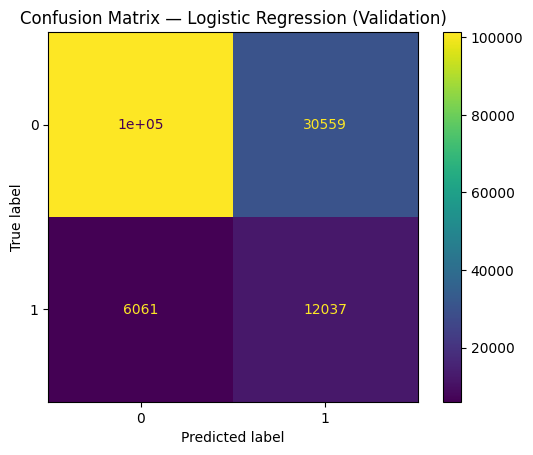

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.77      0.85    131902
           1       0.28      0.67      0.40     18098

    accuracy                           0.76    150000
   macro avg       0.61      0.72      0.62    150000
weighted avg       0.86      0.76      0.79    150000

Validation ROC-AUC: 0.7810309056158574


In [47]:
# Instantiate Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,              
    random_state=42
)

# Fit model on training subset
log_reg.fit(X_train_final, y_train_final)

# Predict on validation set
y_val_pred = log_reg.predict(X_val)
y_val_probs = log_reg.predict_proba(X_val)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title("Confusion Matrix — Logistic Regression (Validation)")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))

# ROC-AUC Score
auc = roc_auc_score(y_val, y_val_probs)
print("Validation ROC-AUC:", auc)

### Logistic Regression Performance (Validation Set)

The baseline Logistic Regression model was evaluated on the validation subset to assess its ability to identify customers likely to subscribe.

---

#### Confusion Matrix Breakdown

- **True Negatives (Correctly predicted non-subscribers):** ~100,000  
- **False Positives (Predicted subscription, but no subscription occurred):** 30,559  
- **False Negatives (Missed subscribers):** 6,061  
- **True Positives (Correctly identified subscribers):** 12,037  

The model captures a substantial portion of potential subscribers, but this comes with a significant number of false positives.

---

#### Classification Metrics

| Class | Precision | Recall | Interpretation |
|------|----------|--------|---------------|
| No Subscription (0) | 0.94 | 0.77 | Strong ability to identify non-subscribers |
| Subscription (1) | 0.28 | 0.67 | Good detection rate, but relatively low precision |

- **Recall (Subscribers) = 67%**  
  → Approximately two-thirds of actual subscribers are correctly identified.

- **Precision (Subscribers) = 28%**  
  → Roughly one in four predicted subscribers actually converts.

---

#### ROC–AUC Score

- **Validation ROC-AUC = 0.78**

An AUC of 0.78 indicates reasonable discriminatory power — the model can meaningfully separate subscribers from non-subscribers — but performance remains far from optimal.

---

### Business Interpretation

As a baseline model, Logistic Regression demonstrates the ability to identify a large share of high-potential customers. However, the relatively low precision implies that many contacted customers would still be unlikely to subscribe.

Operationally, this means:

- The bank would successfully reach many true subscribers  
- Outreach costs would remain elevated due to false positives  

This trade-off highlights the need to either adjust the decision threshold strategically or explore more flexible models — such as Decision Trees and Random Forests — capable of capturing non-linear customer behavior patterns.

## Decision Tree — Interpretable Non-Linear Model

To improve upon the baseline Logistic Regression model, a Decision Tree classifier is introduced.

Decision Trees offer several advantages:

- They automatically capture non-linear relationships  
- They model feature interactions without requiring manual engineering  
- They remain interpretable when depth is properly constrained  

Unlike Logistic Regression, which assumes linear relationships between features and the log-odds of the outcome, Decision Trees can partition the feature space in a more flexible way. This makes them well-suited for customer behavior data, where interactions and threshold effects are common.

This model serves as a logical intermediate step before progressing to more powerful ensemble methods such as Random Forests.


Best parameters: {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV ROC-AUC: 0.8137825701560493


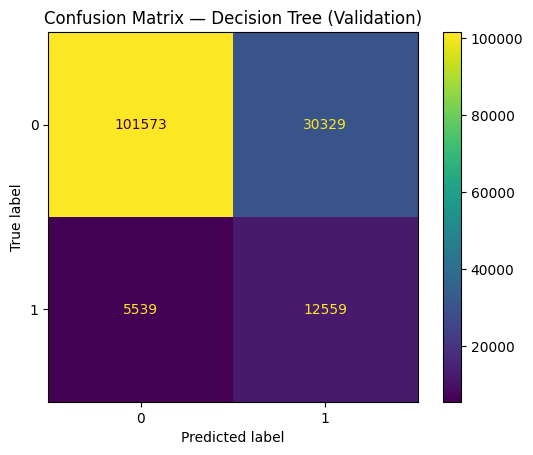

Decision Tree Report (Validation):

              precision    recall  f1-score   support

           0       0.95      0.77      0.85    131902
           1       0.29      0.69      0.41     18098

    accuracy                           0.76    150000
   macro avg       0.62      0.73      0.63    150000
weighted avg       0.87      0.76      0.80    150000

Validation ROC-AUC: 0.8117541874180897


In [50]:
# Base model
tree = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

# Hyperparameter grid
cv_params = {
    "max_depth": [4, 6, 8, 9, None],
    "min_samples_leaf": [2, 5],
    "min_samples_split": [2, 4, 6]
}

# Multi-metric scoring (dictionary)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# GridSearch
tree1 = GridSearchCV(
    estimator=tree,
    param_grid=cv_params,
    scoring=scoring,
    refit="roc_auc",
    cv=3,        
    n_jobs= -1     
)

# Fit on training split ONLY
tree1.fit(X_train_final, y_train_final)

print("Best parameters:", tree1.best_params_)
print("Best CV ROC-AUC:", tree1.best_score_)

# Validate best estimator
best_tree = tree1.best_estimator_
y_val_pred = best_tree.predict(X_val)
y_val_probs = best_tree.predict_proba(X_val)[:, 1]

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="")
plt.title("Confusion Matrix — Decision Tree (Validation)")
plt.show()

print("Decision Tree Report (Validation):\n")
print(classification_report(y_val, y_val_pred))

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_probs))


## Decision Tree — Validation Results

After hyperparameter tuning via cross-validation, the optimized Decision Tree achieved:

- **Best Cross-Validation ROC-AUC:** ~0.814  
- **Validation ROC-AUC:** ~0.812  

This marks a meaningful improvement over the Logistic Regression baseline (0.78), indicating that the Decision Tree is better able to capture non-linear patterns and feature interactions in customer subscription behavior.

---

### Confusion Matrix Interpretation

The validation confusion matrix indicates that the model:

- Maintains strong performance in identifying non-subscribers (class 0)  
- Captures a slightly larger share of actual subscribers compared to the baseline model  

However, this improvement in recall comes with a trade-off:

- A substantial number of false positives remain, meaning many customers predicted to subscribe ultimately do not convert  

---

### Classification Performance (Positive Class: `y = 1`)

- **Recall ≈ 0.69**  
  → Approximately 69% of actual subscribers are correctly identified.

- **Precision ≈ 0.29**  
  → Roughly 29% of predicted subscribers convert.

Compared to Logistic Regression, recall improves slightly, while precision remains relatively low.

---

## Business Interpretation

The tuned Decision Tree delivers stronger predictive power than the baseline model, particularly in detecting potential subscribers.

From a campaign perspective, this model is useful when the priority is:

- **Maximizing recall**;  identifying as many likely subscribers as possible  

However, low precision implies continued inefficiency in outreach efforts. Operationally, this means:

- More potential subscribers are reached  
- But many low-probability customers would still be contacted  

To improve campaign efficiency further, the following steps may be necessary:

- Strategic probability threshold optimization  
- Additional feature engineering  
- More advanced ensemble methods (e.g., Random Forest or Gradient Boosting)  

Overall, the Decision Tree represents a solid intermediate improvement and provides a foundation for exploring more robust tree-based models.

## Extracting Cross-Validation Results (GridSearch Summary)

After tuning the Decision Tree using `GridSearchCV`, it is important to clearly report the model’s optimal performance across validation folds.

Rather than manually reviewing multiple metrics for each experiment, a helper function is implemented to:

- Retrieve the best-performing hyperparameter combination  
- Extract the associated cross-validation scores  
- Present key evaluation metrics in a structured summary table  

This approach improves readability, ensures consistent reporting and simplifies model comparison, particularly when evaluating multiple algorithms (e.g., Decision Tree vs. Random Forest).

By standardizing result extraction, the modeling process becomes more transparent and easier to scale across experiments.

In [53]:
def extract_cv_results(model_name: str, grid_object):
    """
    Summarize the best GridSearchCV result (multi-metric scoring).
    """
    results = pd.DataFrame(grid_object.cv_results_)
    best_idx = grid_object.best_index_

    summary = pd.DataFrame({
        "Model": [model_name],
        "Mean CV ROC-AUC": [results.loc[best_idx, "mean_test_roc_auc"]],
        "Mean CV Precision": [results.loc[best_idx, "mean_test_precision"]],
        "Mean CV Recall": [results.loc[best_idx, "mean_test_recall"]],
        "Mean CV F1": [results.loc[best_idx, "mean_test_f1"]],
        "Mean CV Accuracy": [results.loc[best_idx, "mean_test_accuracy"]],
    })

    return summary

In [54]:
tree_cv_summary = extract_cv_results("Decision Tree (Tuned)", tree1)
tree_cv_summary


,Model,Mean CV ROC-AUC,Mean CV Precision,Mean CV Recall,Mean CV F1,Mean CV Accuracy
0,Decision Tree (Tuned),0.813783,0.294085,0.704545,0.414953,0.760302


## Decision Tree (Tuned) — Cross-Validation Summary

The table above summarizes the tuned Decision Tree’s average performance across cross-validation folds.

### Key Performance Metrics

- **ROC-AUC ≈ 0.814**  
  The model demonstrates strong discriminatory ability, outperforming the Logistic Regression baseline and providing better separation between subscribers and non-subscribers.

- **Recall ≈ 0.705 (Subscribers)**  
  Approximately 70% of actual subscribers are correctly identified. This is valuable when the objective is to capture as many potential conversions as possible.

- **Precision ≈ 0.294 (Subscribers)**  
  Roughly 3 out of 10 predicted subscribers convert. While recall is strong, false positives remain substantial.

- **F1-score ≈ 0.415**  
  This reflects the trade-off between high recall and moderate precision.

- **Accuracy ≈ 0.760**  
  Given the class imbalance (~12% positive rate), accuracy is less informative. Metrics such as ROC-AUC and the precision–recall balance provide a more meaningful assessment.

---

## Business Interpretation

The tuned Decision Tree represents a clear improvement over the baseline model, particularly in its ability to identify likely subscribers.

From a campaign strategy perspective:

- The model is effective as a **prioritization tool**, helping rank customers by subscription likelihood.
- However, given the relatively low precision, it should not be used as a binary “call vs. do not call” decision rule without further threshold optimization.

In practice, the model is best leveraged to target top-scoring customer segments, where the probability of conversion is meaningfully higher.


## Random Forest — Ensemble Model

After establishing a baseline with Logistic Regression and improving performance with a tuned Decision Tree, the next step is to implement a Random Forest classifier.

Random Forest is an ensemble method that aggregates predictions from multiple decision trees, reducing variance and improving overall stability. This approach is particularly effective when:

- Relationships between features and the target are non-linear  
- Individual decision trees are prone to overfitting  
- Stronger generalization is required for deployment  

By averaging across many trees, the model captures complex interactions while mitigating the instability of a single tree.

Given the class imbalance (~12% positive cases), model evaluation is guided primarily by **ROC-AUC**, which measures the model’s ability to distinguish subscribers from non-subscribers across decision thresholds.

To balance performance with computational efficiency, hyperparameter tuning is conducted using a focused and practical search grid.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 3, 'n_estimators': 100}
Best CV ROC-AUC: 0.8411625012519411


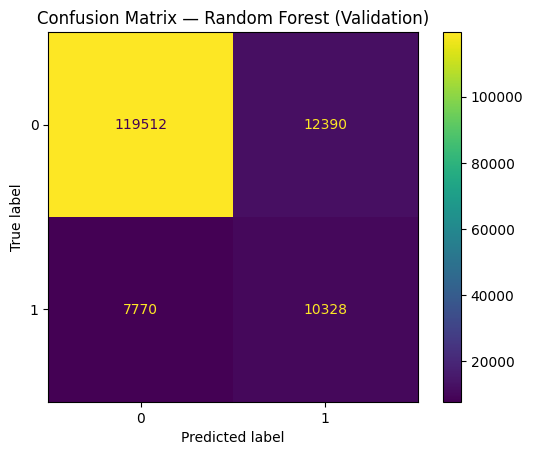

Random Forest Report (Validation):

              precision    recall  f1-score   support

           0       0.94      0.91      0.92    131902
           1       0.45      0.57      0.51     18098

    accuracy                           0.87    150000
   macro avg       0.70      0.74      0.71    150000
weighted avg       0.88      0.87      0.87    150000

Validation ROC-AUC: 0.8394034156861778


In [57]:
# ================================
# Random Forest — GridSearchCV
# ================================

# Base model 
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# Practical hyperparameter grid (small, efficient)
rf_params = {
    "n_estimators": [100],
    "max_depth": [5, None],
    "max_samples": [0.7],
    "min_samples_leaf": [1, 3],
    "max_features": ["sqrt"]
}

# Multi-metric scoring (consistent reporting)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

# GridSearch (refit best model by ROC-AUC)
rf1 = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring=scoring,
    refit="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit on training split only
rf1.fit(X_train_final, y_train_final)

print("Best parameters:", rf1.best_params_)
print("Best CV ROC-AUC:", rf1.best_score_)

# ================================
# Validation Evaluation
# ================================

best_rf = rf1.best_estimator_

y_val_pred = best_rf.predict(X_val)
y_val_probs = best_rf.predict_proba(X_val)[:, 1]

cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm).plot(values_format="")
plt.title("Confusion Matrix — Random Forest (Validation)")
plt.show()

print("Random Forest Report (Validation):\n")
print(classification_report(y_val, y_val_pred))

print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_probs))


## Random Forest — Validation Performance

The tuned Random Forest model delivers the strongest results observed so far, outperforming both Logistic Regression and the Decision Tree baseline.

### Cross-Validated Performance
- **Best Cross-Validation ROC–AUC: 0.841**

This indicates improved ability to rank customers by subscription probability across decision thresholds.

### Validation Metrics
- **Accuracy: 0.87**  
- **Validation ROC–AUC: 0.839**

The validation ROC–AUC closely matches the cross-validated score, suggesting stable generalization and minimal overfitting.

---

### Subscriber Class Performance (`y = 1`)

- **Precision: 0.45**  
  - Approximately 45% of predicted subscribers convert.

- **Recall: 0.57**  
  - The model identifies 57% of all true subscribers.

- **F1-score: 0.51**  
  - Represents a stronger balance between precision and recall compared to previous models.

Relative to earlier models, precision improves substantially while recall remains competitive, resulting in a more efficient targeting profile.

---

## Business Interpretation

The Random Forest model provides the most practical balance between capturing likely subscribers and limiting unnecessary outreach.

Operationally, this means:

- Fewer wasted calls compared to earlier models  
- Strong ranking capability for prioritizing high-probability customers  
- More efficient allocation of marketing resources  

Based on validation performance, Random Forest is the strongest candidate for campaign prioritization and deployment.

## Saving the Model — File Path Setup

To enable reuse and future deployment, trained models (such as the selected Random Forest classifier) are serialized and saved locally using Python’s pickling functionality.

A dedicated directory named `models/` is created within the project structure to:

- Store trained model artifacts  
- Maintain organization and version control  
- Ensure reproducibility of results  

By structuring saved models in a consistent location, the workflow becomes easier to manage, share, and extend for future experimentation or deployment scenarios.

In [60]:
import os

# Define folder name for saving models
model_path = "models/"

# Create the folder if it doesn't already exist
if not os.path.exists(model_path):
    os.makedirs(model_path)

print("Model folder ready at:", model_path)


Model folder ready at: models/


## Pickle Utility — Saving Trained Models

To ensure the project remains reusable outside the notebook environment, trained models are serialized and saved to disk using Python’s `pickle` module.

This approach enables:

- Reloading the model without retraining  
- Reproducing results consistently  
- Integrating the model into future deployment pipelines  

By persisting the trained model as a file artifact, we separate model training from model usage — a critical step for operational efficiency in real-world systems.

In [62]:
import pickle
def write_pickle(path, model_object, save_as:str):
    """
    Saves a trained model object as a pickle file.

    Parameters:
        path (str): Folder where the model will be stored
        model_object: The trained model (or GridSearchCV object)
        filename (str): Name of the saved file (without extension)
    """
    
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)


## Loading Saved Models

After saving a trained model, it is essential to verify that it can be successfully reloaded and reused.

This validation step ensures that:

- The serialized model file is intact  
- Predictions can be generated without retraining  
- The workflow remains reproducible across environments  

In real-world business settings, models are typically trained once and deployed into production systems where predictions are generated independently of the training process. Confirming successful reloading simulates this deployment scenario and validates the end-to-end pipeline.

In [64]:
def read_pickle(path, saved_model_name:str):
    """
    Loads a saved pickle model file from disk.

    Parameters:
        path (str): Folder where the model is stored
        filename (str): Name of the saved file (without extension)

    Returns:
        model: The reloaded model object
    """

    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)
    
    return model

In [65]:
# Save fitted GridSearchCV objects
write_pickle(model_path, tree1, "decision_tree_gs")
write_pickle(model_path, rf1, "random_forest_gs")

## Model Persistence (Saving Results)

To avoid retraining computationally expensive models each time the notebook is reopened, the fitted `GridSearchCV` objects are serialized and saved to disk using Python’s pickling functionality.

Saving the full `GridSearchCV` object (rather than only the final estimator) preserves:

- The best-performing hyperparameters  
- Cross-validation results  
- The complete tuning configuration  

This allows the tuned Decision Tree and Random Forest models to be quickly reloaded for:

- Performance evaluation  
- Model comparison  
- Threshold optimization  
- Future deployment  

By persisting these objects, the modeling workflow becomes more efficient, reproducible, and scalable — especially when working with large datasets and time-intensive tuning procedures.

## Extracting Cross-Validation Results (Model Comparison)

To compare model architectures objectively, the best cross-validation results from each tuned model are consolidated into a single summary.

This ensures a consistent evaluation framework and allows direct comparison across algorithms trained on an imbalanced marketing outcome.

**ROC–AUC** is used as the primary comparison metric, as it reflects each model’s ability to distinguish subscribers from non-subscribers across decision thresholds.

Complementary metrics;  **precision, recall, and F1-score** provide additional insight into the operational trade-off between:

- Capturing as many likely subscribers as possible  
- Minimizing wasted outreach to low-probability customers  

By aligning model comparison with business objectives, selection decisions remain both statistically sound and strategically relevant.


In [68]:
# Cross-validation summaries
tree_cv_summary = extract_cv_results("Decision Tree (Tuned)", tree1)
rf_cv_summary = extract_cv_results("Random Forest (Tuned)", rf1)

# Combined comparison table
model_cv_summary = pd.concat([tree_cv_summary, rf_cv_summary], ignore_index=True)
model_cv_summary.sort_values("Mean CV ROC-AUC", ascending=False)


,Model,Mean CV ROC-AUC,Mean CV Precision,Mean CV Recall,Mean CV F1,Mean CV Accuracy
1,Random Forest (Tuned),0.841163,0.457108,0.569996,0.507346,0.866442
0,Decision Tree (Tuned),0.813783,0.294085,0.704545,0.414953,0.760302


## Cross-Validation Model Comparison

The table above summarizes the best cross-validation performance of the tuned Decision Tree and Random Forest models.

Overall, the **Random Forest** achieves a higher ROC–AUC and a stronger precision–F1 balance, indicating superior ranking ability and more efficient identification of likely subscribers.

While the Decision Tree demonstrates slightly stronger recall, this comes at the expense of substantially lower precision and weaker overall predictive power.

Considering both statistical performance and business trade-offs, Random Forest is selected as the leading candidate for final interpretation and campaign recommendations.

## Final Model Evaluation

Because the Kaggle test dataset does not include ground-truth subscription labels (`y`), it cannot be used to compute performance metrics.

Instead, all quantitative evaluation is conducted using the holdout validation set derived from the training data. This provides a reliable estimate of how the model is expected to perform on unseen customers.

The Kaggle test dataset is reserved exclusively for **deployment simulation**, generating subscription probability predictions as would occur in a real marketing campaign.

## Feature Importance — What Drives Subscription?

With Random Forest selected as the final model, the focus now shifts to interpretability.

Understanding which variables most influence predictions is essential in a business setting. It allows stakeholders to move beyond performance metrics and understand the underlying drivers of subscription behavior.

Interpreting feature importance serves three key purposes:

- Identifying the strongest drivers of term deposit subscription  
- Building trust in the model’s recommendations  
- Supporting actionable marketing strategies rather than relying on opaque “black-box” outputs  

The following analysis examines feature importance derived from the Random Forest model, highlighting the variables that contribute most to predicting whether a client will subscribe.


In [72]:
# Extract feature importances from the best Random Forest model
importances = best_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 10 most important features
feature_importance_df.head(10)


,Feature,Importance
1,balance,0.265955
0,age,0.120004
2,day,0.102425
26,contact_unknown,0.069767
3,campaign,0.057722
39,poutcome_success,0.044901
23,housing_yes,0.044848
4,pdays,0.043024
24,loan_yes,0.018008
5,previous,0.017588


### Feature Importance Visualization

The table above ranks features by their relative importance in the Random Forest model.

To make these differences easier to interpret, the importance scores are visualized in a bar plot. This allows for a clearer comparison of how strongly each variable contributes to predicting subscription likelihood.

From the ranking, several drivers stand out:

- **Balance** is the dominant predictor, indicating financial capacity plays a central role.
- **Age** and **day of contact** also contribute meaningfully.
- Campaign-related variables such as **contact type**, **campaign frequency**, and **previous outcome success** show strong behavioral influence.

Visualizing these importance scores reinforces the conclusion that both financial strength and campaign strategy significantly shape term deposit subscription behavior.

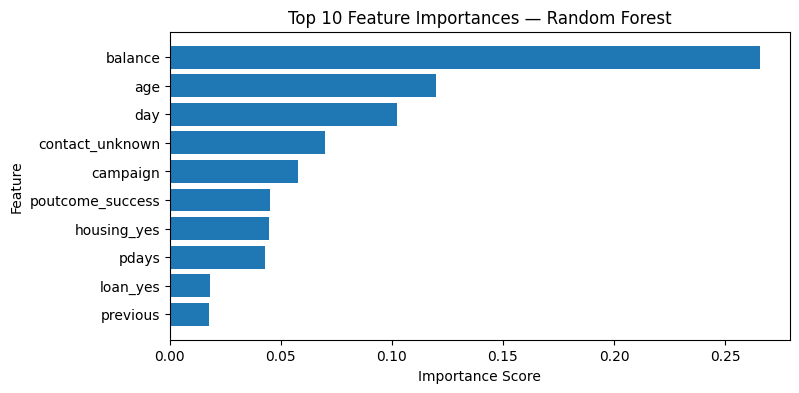

In [74]:
plt.figure(figsize=(8,4))
plt.barh(
    feature_importance_df["Feature"].head(10)[::-1],
    feature_importance_df["Importance"].head(10)[::-1]
)

plt.title("Top 10 Feature Importances — Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Top Feature Importances — Random Forest

The chart above highlights the **10 most influential variables** used by the Random Forest model to predict term deposit subscription.

### Key Observations

- **Balance emerges as the dominant predictor.**  
  Customers with higher account balances show a substantially greater likelihood of subscribing, reinforcing the importance of financial capacity in investment decisions.

- **Age ranks as the second most influential feature.**  
  This suggests that life stage and financial maturity meaningfully shape subscription behavior.

- **Timing effects appear relevant.**  
  The variable `day` ranks among the top contributors, indicating that the timing of outreach may influence responsiveness.

- **Contact channel quality matters.**  
  The presence of `contact_unknown` among the top features suggests that incomplete or poorly defined communication channels negatively affect conversion probability.

- **Campaign intensity plays a role.**  
  The `campaign` variable (number of contact attempts) indicates that repeated outreach may influence outcomes, potentially reflecting diminishing returns.

### Historical Engagement Signals

- **Previous campaign success (`poutcome_success`) is a strong indicator.**  
  Customers who converted in prior campaigns are significantly more likely to convert again.

- **Prior engagement metrics (`pdays`, `previous`) add additional predictive value**, reinforcing that historical interaction patterns shape current behavior.

### Financial Obligations and Conversion

- Features such as `housing_yes` and `loan_yes` suggest that existing debt commitments may reduce the likelihood of subscribing to additional financial products.

---

## Business Takeaway

The Random Forest model highlights several actionable drivers of subscription behavior.

Campaign efficiency can likely be improved by prioritizing customers who:

- Maintain higher account balances  
- Have demonstrated prior positive engagement  
- Are reachable through clearly defined contact channels  
- Carry fewer competing financial obligations  

These insights support more strategic outreach allocation, enabling the bank to concentrate resources where conversion probability is meaningfully higher.

# Final Model Recommendation and Business Insights

## Model Selection

After evaluating multiple classification approaches, the **Random Forest model** emerged as the strongest performer for this business problem.

Relative to Logistic Regression and the tuned Decision Tree, Random Forest demonstrated:

- Higher **ROC–AUC**
- A stronger balance between **precision and recall**
- More efficient identification of likely subscribers

Based on validation performance and business trade-offs, Random Forest is the most suitable model for supporting real-world campaign targeting decisions.

---

## Key Business Recommendations

The model results and feature importance analysis translate into several practical actions for improving term deposit campaign efficiency.

---

### 1. Prioritize High-Balance Customers

Account balance was the most influential predictor.

**Recommendation:**  
Concentrate outreach efforts on customers with stronger financial reserves, as they exhibit meaningfully higher subscription likelihood.

---

### 2. Improve Contact Data Quality

The feature `contact_unknown` emerged as a strong negative signal.

**Recommendation:**  
Strengthen data collection and validation processes to ensure contact methods are accurate and complete. Poor communication data directly reduces campaign effectiveness.

---

### 3. Leverage Prior Campaign Success

Previous campaign success (`poutcome_success`) significantly increases the probability of future subscription.

**Recommendation:**  
Treat prior converters as high-priority leads for future deposit campaigns and incorporate historical engagement into segmentation strategy.

---

### 4. Segment Customers with Existing Loan Obligations

Customers with housing or personal loans were less likely to subscribe.

**Recommendation:**  
Design differentiated messaging or separate campaign strategies for these segments, as their financial priorities may differ.

---

### 5. Monitor Campaign Fatigue

The number of contact attempts (`campaign`) influences outcomes, with repeated outreach showing diminishing returns.

**Recommendation:**  
Implement contact caps or dynamic outreach rules to avoid over-contacting low-response customers.

---

## Practical Value of the Model

The Random Forest classifier provides a data-driven mechanism to:

- Rank customers by subscription probability **before outreach**
- Allocate marketing resources more strategically
- Reduce unnecessary calls to low-probability segments
- Improve overall conversion efficiency

Rather than expanding outreach volume, the model enables smarter targeting.

---

## Limitations

Several considerations should be acknowledged:

- The dataset is imbalanced (~12% positive class), making recall and ROC–AUC more informative than raw accuracy.
- Seasonal and behavioral patterns may shift over time, requiring periodic monitoring and retraining.
- The model is trained on historical campaign data and may require recalibration for future campaigns.

---

## Next Steps

Future enhancements could include:

- Testing gradient boosting models (e.g., LightGBM or XGBoost) for incremental performance gains  
- Engineering additional campaign-history features  
- Optimizing probability thresholds based on explicit cost–benefit trade-offs  
- Integrating the model into a campaign decision-support workflow  

---

## Conclusion

This project demonstrates how machine learning can enhance banking marketing operations by predicting term deposit subscription likelihood prior to outreach.

The final Random Forest model delivers strong predictive performance while generating actionable insights, enabling more efficient, data-driven customer targeting.